## Import section

In [1]:
import glob
import bs4 as bs
import csv
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Grobid extraction information

In [2]:
print("Number of pdf with complete extraction:",len(glob.glob("../../Results/extraction/grobid_extraction/*.xml")))
print("Number of pdf with error extraction:",len(glob.glob("../../Results/extraction/grobid_extraction/*.txt")))
print("Total number of paper:",len(glob.glob("../../Results/extraction/fulltext/*.pdf")))

Number of pdf with complete extraction: 2678
Number of pdf with error extraction: 0
Total number of paper: 2678


## Load dataset information

In [3]:
datasets_info = {}
with open('../../Resources/data/datasets.csv') as ds_csv:
    ds_reader = csv.DictReader(ds_csv)
    for ds in ds_reader:
        datasets_info[ds["name"]] = {
                                        "doi":ds["doi"],
                                        "title":ds["paper_title"],
                                        "name":ds["name"],
                                        "aliases":ds["aliases"].split(","),
                                        "url":ds["url"].split(",")
                                     }
datasets_info

{'ACDC': {'doi': '10.1109/TMI.2018.2837502',
  'title': 'Deep Learning Techniques for Automatic MRI Cardiac Multi-Structures Segmentation and Diagnosis: Is the Problem Solved?',
  'name': 'ACDC',
  'aliases': ['ACDC', 'Automated Cardiac Diagnosis Challenge', 'AC17'],
  'url': ['https://www.creatis.insa-lyon.fr/Challenge/acdc',
   'https://www.creatis.insa-lyon.fr/Challenge/acdc/databases.html']},
 'Sunnybrook': {'doi': 'https://doi.org/10.54294/g80ruo',
  'title': 'Evaluation Framework for Algorithms Segmenting Short Axis Cardiac MRI.',
  'name': 'Sunnybrook',
  'aliases': ['Sunnybrook'],
  'url': ['https://www.cardiacatlas.org/sunnybrook-cardiac-data']},
 'STACOM’11': {'doi': '10.1007/978-3-642-28326-0_9',
  'title': 'Left Ventricular Segmentation Challenge from Cardiac MRI: A Collation Study',
  'name': 'STACOM’11',
  'aliases': ['STACOM’11', "STACOM'11"],
  'url': ['https://www.satdl.com/download/37618']},
 'RVSC': {'doi': 'https://doi.org/10.1016/j.media.2014.10.004',
  'title': 'R

## Specify datasets selected and sections considered as Method

In [4]:
datasets_columns = ["ACDC","BRATS","LIDC-IDRI","DRIVE","PROMISE12","Chexpert","PadChest","PAD-UFES-20","CAMELYON","CADDementia","MRNet","PROSTATEx","MIMIC","CBIS-DDSM"]
lst_keywords = ["data","method","result","setup","material","experiment","evaluat"]

In [5]:
#Get the results of grobid parsing
xml_paths = glob.glob("../../Results/extraction/grobid_extraction/*")

#res will contain an element (dict) per paper, in each element keys will be datasets' name and value a list of mention location
res = []
for i,path in enumerate(xml_paths):
    paper_name = path.removeprefix("../../Results/extraction/grobid_extraction/").removesuffix(".grobid.tei.xml").removesuffix(".txt")
    
    #Check that the result is an xml, otherwise grobid had an error during the parsing and generate a .txt file
    if path.endswith(".xml"):
        #Load the xml file with BeautifulSoup for parsing
        with open(path) as fp:
            soup = bs.BeautifulSoup(fp,features="xml")


        #Get main section name, it will be used to assign subsection to the main one (e.g section 3.2 match with section 3.)
        sections = {}
        for elem in soup.findAll("head"):
            if elem.get("n") and elem.get("n")[0] not in sections:
                sections[elem.get("n")[0]] = elem.text.lower()
          
        #Search for the mention of every dataset one by one
        for ds in datasets_info:
            #Construct the regex for matching name or aliases, example for ACDC: (?<![^_\W])(ACDC)|(Automated Cardiac Diagnosis Challenge)|(AC17)(?![^_\s\d\.\),'])
            ds_urls = [f"((https://)?{re.escape(url.removeprefix('https://').removeprefix("http://"))}(/)?)" for url in datasets_info[ds]['url']]
            ds_name_aliases = [f"({re.escape(a)})" for a in datasets_info[ds]["aliases"]]
            
            ds_name_aliases_url_regex = "|".join(ds_name_aliases+ds_urls)
            
            #For every element in the xml with a matching, try to associate it with a location or a structure (Figure, Table, Footnote)
            for elem in soup.findAll(string=re.compile(f"(?<![^_\\W])({ds_name_aliases_url_regex})(?![^_\\s\\d\\.\\),'-])")):
                #To detect in "normal" text for which the parent elements is a <div>
                parent_div = elem.find_parent("div")
                if parent_div:
                    #If the element was part of the abstract or an appendix, the div will have a parent abstract or annex.
                    #Otherwise it's part of a fulltext's section
                    if parent_div.find_parent("abstract"):
                        res.append([paper_name,ds,"In Abstract",True])
                    elif (parent_div.find_parent("div")) and (parent_div.find_parent("div").get("type") == "annex"):
                        res.append([paper_name,ds,"Elsewhere",True])
                    elif parent_div.find("head"):
                        #Get the section number
                        head_level = parent_div.find("head").get("n")
                        
                        #Interpolate the section in case there is no "n" attribute by looking at the closest previous div with this attribute
                        if not head_level:
                            for div in parent_div.find_previous_siblings("div"):
                                if div.find("head") and div.find("head").get("n"):
                                    head_level = div.find("head").get("n")
                                    break
                        
                        #Match with a main section if it was a subsection (3.2 -> 3) and get the section name
                        if head_level:
                            head_text = sections[head_level[0]]
                        else:
                            head_text = parent_div.find("head").text.lower()
                        
                        
                        if any([kw in head_text for kw in lst_keywords]):
                            to_append = "In Method"
                        else:
                            to_append = "Elsewhere"
                        res.append([paper_name,ds,to_append,True])
                

                #To detect in figures or tables, for which parent element is <figure>
                parent_figure = elem.find_parent("figure")
                if parent_figure:
                    if parent_figure.get("type") == "table":
                        res.append([paper_name,ds,"In Table",True])                        
                    else:
                        res.append([paper_name,ds,"In Figure",True])
                        

                #To detect footnotes for which parent element is <note>
                parent_footnote = elem.find_parent("note")
                if parent_footnote:
                    if parent_footnote.get("place") == "foot":
                        res.append([paper_name,ds,"In Footnote",True])

In [12]:
df_res = pd.DataFrame(res,columns=["doc_name","label1","label2","value"])
df_res = df_res.drop_duplicates(["doc_name","label1","label2"])
df_res.to_csv("../../Results/extraction/grobid_fulltext_detection2.csv",index=False)

In [11]:
doc_name = r"A Robust Volumetric Transformer for Accurate 3D Tumor Segmentation"
df_res[df_res["doc_name"] == doc_name]

,doc_name,label1,label2,value
73,A Robust Volumetric Transformer for Accurate 3...,BRATS,In Abstract,True
74,A Robust Volumetric Transformer for Accurate 3...,BRATS,Elsewhere,True
75,A Robust Volumetric Transformer for Accurate 3...,BRATS,In Table,True


## Example of regex used for detection

In [17]:
ds = "MIMIC"
ds_urls = [f"((https://)?{re.escape(url.removeprefix('https://').removeprefix("http://"))}(/)?)" for url in datasets_info[ds]['url']]
ds_name_aliases = [f"({re.escape(a)})" for a in datasets_info[ds]["aliases"]]
            

ds_name_aliases_url_regex = "|".join(ds_name_aliases+ds_urls)
regex = re.compile(f"(?<![^_\\W])({ds_name_aliases_url_regex})(?![^_\\s\\d\\.\\),'])")
regex

re.compile(r"(?<![^_\W])((MIMIC)|(MIMIC\-II)|(MIMIC\-III)|(MIMIC\-CXR)|((https://)?archive\.physionet\.org/physiobank/database/mimicdb(/)?)|((https://)?archive\.physionet\.org/physiobank/database/mimic2cdb(/)?)|((https://)?physionet\.org/content/mimiciii/1\.4(/)?)|((https://)?physionet\.org/content/mimic\-cxr/2\.0\.0(/)?)|((https://)?www\.physionet\.org/content/mimic\-cxr\-jpg/2\.0\.0(/)?))(?![^_\s\d\.\),'])",
           re.UNICODE)

## Dataviz

<Figure size 640x480 with 0 Axes>

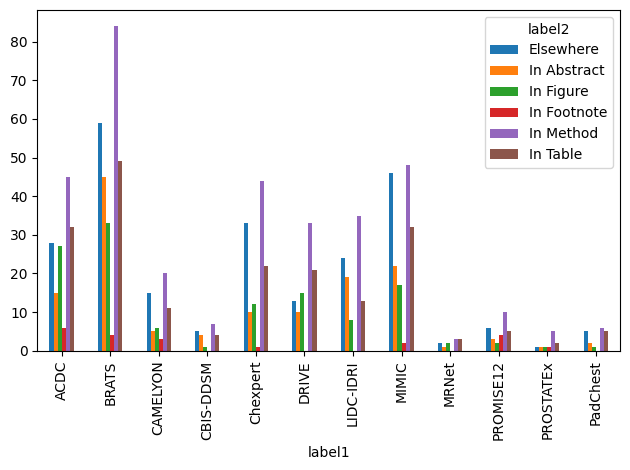

label2,Elsewhere,In Abstract,In Figure,In Footnote,In Method,In Table
label1,,,,,,
ACDC,28.0,15.0,27.0,6.0,45.0,32.0
BRATS,59.0,45.0,33.0,4.0,84.0,49.0
CAMELYON,15.0,5.0,6.0,3.0,20.0,11.0
CBIS-DDSM,5.0,4.0,1.0,0.0,7.0,4.0
Chexpert,33.0,10.0,12.0,1.0,44.0,22.0
DRIVE,13.0,10.0,15.0,0.0,33.0,21.0
LIDC-IDRI,24.0,19.0,8.0,0.0,35.0,13.0
MIMIC,46.0,22.0,17.0,2.0,48.0,32.0
MRNet,2.0,1.0,2.0,0.0,3.0,3.0


In [18]:
df_dataset = df_res[['label1','label2','value']].groupby(['label1','label2']).sum().unstack().fillna(0).droplevel(0,axis=1)
plt.figure()
df_dataset[df_dataset.index.isin(datasets_columns)].plot.bar()
plt.tight_layout()
plt.show()
df_dataset[df_dataset.index.isin(datasets_columns)]

## Difference with manual Annotations

### Load annotations

In [6]:
lst_df = []
lst_annotators = ["Amelia","Dovile","Theo","Veronika"]
for ann in lst_annotators:
    df = pd.read_csv(f"../../Results/annotations/{ann}.csv")
    lst_df.append(df)
df_annotation = pd.concat(lst_df)
df_tracked = df_annotation[df_annotation["label1"].isin(datasets_columns)]
df_tracked.to_csv("../../Results/annotations/annotation_merged.csv")

df_tracked = df_tracked[~df_tracked["label2"].isin(["Used"])]

In [14]:
df_tracked[df_tracked["label1"]=="Drive"]

,doc_id,doc_name,label1,label2,value


In [7]:
df_res_tracked = df_res[df_res["label1"].isin(datasets_columns)]

NameError: name 'df_res' is not defined

### Get differences

In [40]:
with open("../../Results/annotations/diff2.csv","w") as diff_file:
    diff_file.write("doc_name,label1,label2,value_annotation,value_detection")
    for doc_name in df_tracked["doc_name"].unique():
        if doc_name in df_res_tracked["doc_name"].unique():
            detection = df_res_tracked[(df_res_tracked["doc_name"] == doc_name) & (df_res_tracked["value"] == True)]
            annotations = df_tracked[(df_tracked["doc_name"] == doc_name) & (df_tracked["value"] == True)]
            #Get differences where Annotation is True and Detection is False
            for row in annotations.iterrows():
                row_value = row[1]
                if row_value["label1"] not in detection["label1"].unique():
                    diff_file.write(f'\n{row_value["doc_name"]},{row_value["label1"]},{row_value["label2"]},True,False')
                elif row_value["label2"] not in detection["label2"].unique():
                    diff_file.write(f'\n{row_value["doc_name"]},{row_value["label1"]},{row_value["label2"]},True,False')
        
            #Get differences where Detection is True and Annotation is False
            for row in detection.iterrows():
                row_value = row[1]
                if row_value["label1"] not in annotations["label1"].unique():
                    diff_file.write(f'\n{row_value["doc_name"]},{row_value["label1"]},{row_value["label2"]},False,True')
                elif row_value["label2"] not in annotations["label2"].unique():
                    diff_file.write(f'\n{row_value["doc_name"]},{row_value["label1"]},{row_value["label2"]},False,True')

### Analyses errors

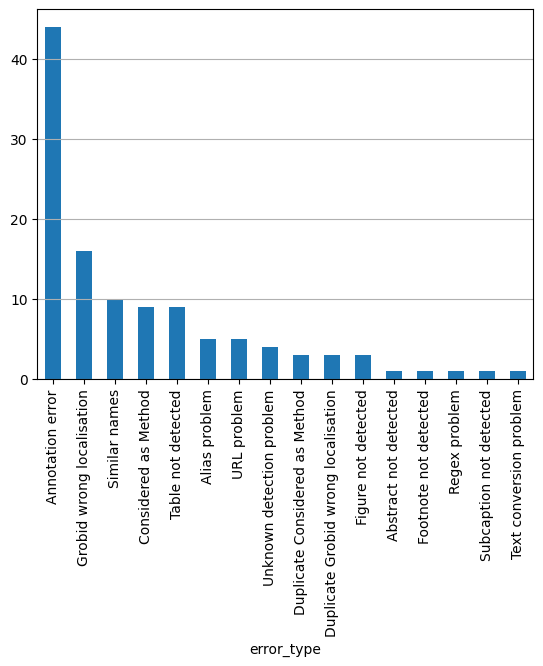

,doc_name
error_type,
Annotation error,44
Grobid wrong localisation,16
Similar names,10
Considered as Method,9
Table not detected,9
Alias problem,5
URL problem,5
Unknown detection problem,4
Duplicate Considered as Method,3


In [150]:
df_diff = pd.read_csv("../../Results/annotations/diff_annotated.csv")
plt.figure()
df_diff.groupby("error_type").count()["doc_name"].sort_values(ascending=False).plot.bar().grid(axis='y')
plt.show()
display(df_diff.groupby("error_type").count()["doc_name"].sort_values(ascending=False).to_frame())

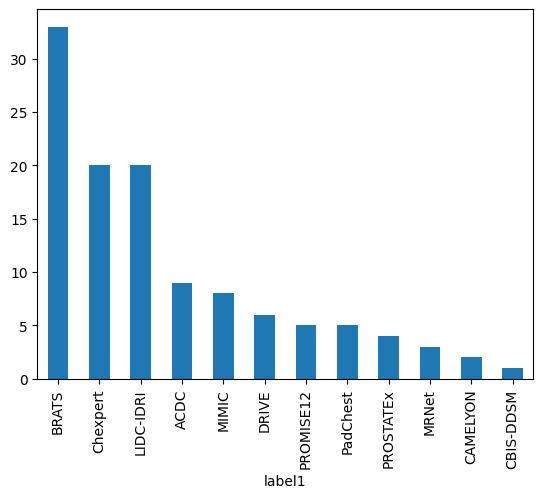

,doc_name
label1,
BRATS,33
Chexpert,20
LIDC-IDRI,20
ACDC,9
MIMIC,8
DRIVE,6
PROMISE12,5
PadChest,5
PROSTATEx,4


In [154]:
plt.plot()
df_diff.groupby("label1").count()["doc_name"].sort_values(ascending=False).plot.bar()
plt.show()
df_diff.groupby("label1").count()["doc_name"].sort_values(ascending=False).to_frame()

## Match with reference detection 

In [8]:
df_ref = pd.read_csv("../../Results/extraction/oa_papers_datasets_reference.csv")
ref_format_annotation = []
for row in df_ref.iterrows():
    row_value = row[1]
    for ds in datasets_columns:
        if row_value[ds]:
            ref_format_annotation.append((row_value["name"],ds,True))
        else:
            ref_format_annotation.append((row_value["name"],ds,False))
df_ref_format_annotation = pd.DataFrame(ref_format_annotation,columns=["doc_name","label1","value"])

In [9]:
df_ref_format_annotation.to_csv("../../Results/extraction/oa_reference_paper_dataset_location_format.csv",index=False)

In [45]:
def match_fulltextdetection(doc_name,label,df_detection):
    if doc_name in df_detection["doc_name"].unique():
        if df_detection[(df_detection["doc_name"] == doc_name) & (df_detection["label1"] == label) & (df_detection["label2"] != "Elsewhere")]["value"].any():
            return True
        else:
            return False
    else:
        return False
df_ref_format_annotation["detection"] = df_ref_format_annotation.apply(lambda x:match_fulltextdetection(x["doc_name"],x["label1"],df_res),axis=1)

In [46]:
print(f"Citation and Mention:{df_ref_format_annotation[(df_ref_format_annotation["value"]==True)&(df_ref_format_annotation["detection"]==True)].count()["value"]}")
print(f'No Citation but Mention: {df_ref_format_annotation[(df_ref_format_annotation["value"]==False)&(df_ref_format_annotation["detection"])].count()["value"]}')
print(f'Citation but no Mention: {df_ref_format_annotation[(df_ref_format_annotation["value"]==True)&(df_ref_format_annotation["detection"]==False)].count()["value"]}')

Citation and Mention:139
No Citati119on but Mention: 119
Citation but no Mention: 260


<Axes: xlabel='label1'>

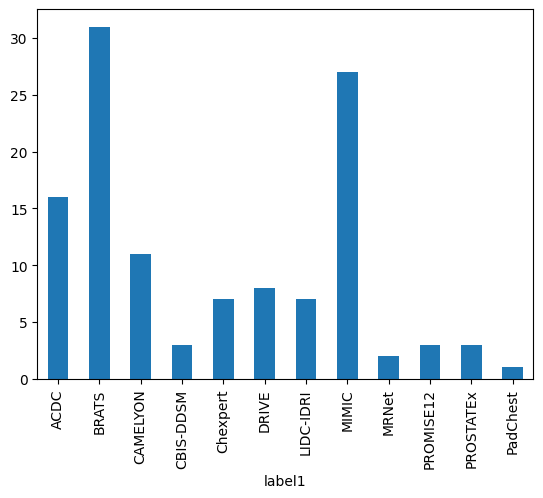

In [47]:
df_ref_format_annotation[(df_ref_format_annotation["value"]==False)&(df_ref_format_annotation["detection"])].groupby("label1").count()["detection"].plot.bar()